## Imports

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Dataset
import numpy as np
import pickle
import math

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

## Données JSB Chorales


### Chargement des données

In [ ]:
!mkdir -p ./data
!wget https://github.com/czhuang/JSB-Chorales-dataset/raw/master/jsb-chorales-16th.pkl -O ./data/jsb-chorales-16th.pkl
!apt-get install -y fluidsynth
!pip install pyfluidsynth
!pip install pretty_midi



--2025-12-01 18:10:41--  https://github.com/czhuang/JSB-Chorales-dataset/raw/master/jsb-chorales-16th.pkl
Resolving github.com (github.com)... 140.82.116.4
Connecting to github.com (github.com)|140.82.116.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/czhuang/JSB-Chorales-dataset/master/jsb-chorales-16th.pkl [following]
--2025-12-01 18:10:41--  https://raw.githubusercontent.com/czhuang/JSB-Chorales-dataset/master/jsb-chorales-16th.pkl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8513713 (8.1M) [application/octet-stream]
Saving to: ‘./data/jsb-chorales-16th.pkl’

./data/jsb-chorales 100%[===================>]   8.12M  --.-KB/s    in 0.06s   

2025-12-01 18:10:42 (128 MB/s) - ‘./data/jsb-ch

In [ ]:

with open('./data/jsb-chorales-16th.pkl', 'rb') as f:
    data = pickle.load(f, encoding='latin1')

print(data.keys())
print(len(data['train']))
print(len(data['valid']))
print(len(data['test']))

print(data['train'][0][:5])


dict_keys(['test', 'train', 'valid'])
229
76
77
[(np.int64(74), np.int64(70), np.int64(65), np.int64(58)), (np.int64(74), np.int64(70), np.int64(65), np.int64(58)), (np.int64(74), np.int64(70), np.int64(65), np.int64(58)), (np.int64(74), np.int64(70), np.int64(65), np.int64(58)), (np.int64(75), np.int64(70), np.int64(58), np.int64(55))]


In [ ]:
import pretty_midi
from IPython.display import Audio

def play_jsb_sequence(sequence, fs=4, filename="jsb_sequence.mid"):
    """
    Joue une séquence JSB-Chorales.


    :param sequence: liste de pas de temps, chaque pas de temps est une liste de notes MIDI jouées
    :type sequence: list of list of int
    :param fs: nombre de pas par seconde (durée d'un pas = 1/fs s)
    :type fs: int
    :param filename: nom du fichier MIDI à sauvegarder
    :type filename: str
    :return: Audio object
    :rtype: IPython.display.Audio
    """
    pm = pretty_midi.PrettyMIDI()
    piano = pretty_midi.Instrument(program=0)

    T = len(sequence)
    notes_active = {}

    for t, notes in enumerate(sequence):
        notes = set(notes)
        # Activer les nouvelles notes
        for pitch in notes:
            if pitch not in notes_active:
                notes_active[pitch] = t / fs
        # Désactiver les notes
        for pitch in list(notes_active.keys()):
            if pitch not in notes:
                start = notes_active[pitch]
                end = t / fs
                piano.notes.append(pretty_midi.Note(velocity=100, pitch=pitch, start=start, end=end))
                del notes_active[pitch]

    # Fermer les notes restantes
    for pitch, start in notes_active.items():
        piano.notes.append(pretty_midi.Note(velocity=100, pitch=pitch, start=start, end=T/fs))

    pm.instruments.append(piano)
    pm.write(filename)
    audio_data = pm.fluidsynth(fs=44100)
    return Audio(audio_data, rate=44100)


In [ ]:

play_jsb_sequence(data['train'][100], fs=10)


In [ ]:
def midi_to_pianoroll(seq):
    """
    Convertit une séquence de notes MIDI en un piano-roll binaire.

    :param seq: Séquence de pas de temps. Chaque pas de temps est une liste contenant les numéros de notes MIDI jouées à cet instant.
    :type seq: List

    :return: Tableau binaire représentant le piano-roll de la séquence.
    :rtype: np.ndarray
    """
    T = len(seq)
    pianoroll = np.zeros((T, 88), dtype=np.float32)
    for t, notes in enumerate(seq):
        for n in notes:
            if n is None or np.isnan(n):
                continue
            n_int = int(n)
            if 21 <= n_int <= 108:
                pianoroll[t, n_int - 21] = 1.0
    return pianoroll


In [ ]:
def pianoroll_to_midi(pianoroll):
    """
    Convertit un piano-roll binaire en séquence MIDI.

    :param pianoroll: Piano-roll binaire [T, 88], 1 = note jouée, 0 = silence
    :type pianoroll: np.ndarray ou torch.Tensor

    :return: Liste de T pas de temps, chaque pas contenant les numéros MIDI joués
    :rtype: List[List[int]]
    """
    if isinstance(pianoroll, torch.Tensor):
        pianoroll = pianoroll.cpu().numpy()

    T, N = pianoroll.shape
    assert N == 88, "Pas le bon format."

    seq = []
    for t in range(T):
        notes = [i + 21 for i in range(88) if pianoroll[t, i] ==1]
        seq.append(notes)

    return seq


In [ ]:

from typing import List, Dict

class JSBDataset(Dataset):

    def __init__(self, data : Dict, seq_len : int =32, split : str ='train'):
      """
      Initialization

      :param data: Données du datasets à créer
      :type data: dict
      :param seq_len: longeur des segments de notes
      :param split: int
      """
      self.sequences = []
      for seq in data[split]:
          pr = midi_to_pianoroll(seq)
          T = pr.shape[0]
          for i in range(0, T - seq_len + 1, seq_len):
              self.sequences.append(pr[i:i+seq_len])
      self.sequences = torch.tensor(self.sequences, dtype=torch.float32)

    def __len__(self) -> int:
      """
      Retourne la longeur du dataset
      """
      return len(self.sequences)

    def __getitem__(self, idx) -> torch.Tensor :
      """
      Retourne un segment de notes

      :param idx: indice du segment
      :type idx: int
      :return: segment de notes
      :rtype: torch.Tensor
      """
      return self.sequences[idx]


# Création des datasets
seq_len = 32
batch_size = 64

train_dataset = JSBDataset(data, seq_len=seq_len, split='train')
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = JSBDataset(data,seq_len=seq_len,split="test")
test_loader = DataLoader(test_dataset,batch_size =batch_size, shuffle = True)

for batch in train_loader:
    print(batch.shape)
    break


/tmp/ipython-input-2258251113.py:20: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  self.sequences = torch.tensor(self.sequences, dtype=torch.float32)


torch.Size([64, 32, 88])


In [ ]:
# Extraction d'un segment et transformation en piste audio

notes1 = pianoroll_to_midi(batch[0])
audio1 = play_jsb_sequence(notes1)
display(audio1)

In [ ]:
def plot_piano_sequences(sequences : List, indices=None, titles=None, cmap='gray_r'):
    """
    Affiche des séquences de piano-roll sous forme de graphiques.


    :param sequences: séquences à afficher
    :type sequences: list or np.ndarray or torch.Tensor
    :param indices: indices des séquences à afficher, si None, affiche toutes les séquences
    :type indices: list of int, optional
    :param titles: titres des séquences, si None, utilise "Sequence i"
    :type titles: list of str, optional
    :param cmap: couleur du piano-roll, par défaut 'gray_r'
    :type cmap: str, optional

    """

    if indices is None:
        indices = range(len(sequences))
    if titles is None:
        titles = [f"Sequence {i}" for i in indices]

    for i, idx in enumerate(indices):
        seq = sequences[idx]
        if isinstance(seq, torch.Tensor):
            seq = seq.cpu().numpy()
        plt.figure(figsize=(10, 3))
        plt.imshow(seq.T, aspect='auto', cmap=cmap)
        plt.xlabel("Time steps")
        plt.ylabel("Notes")
        plt.title(titles[i])
        plt.colorbar(label="Amplitude")
        plt.show()


torch.Size([64, 32, 88])


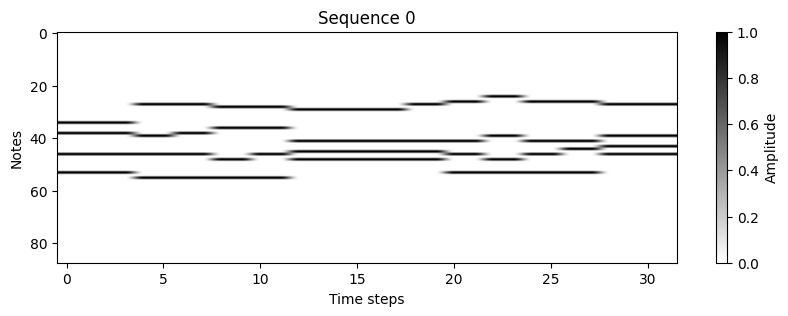

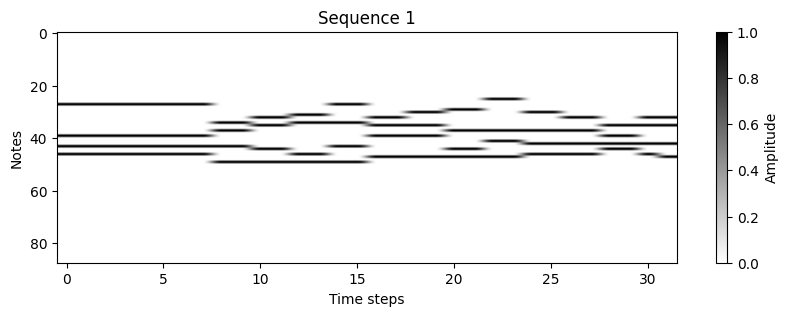

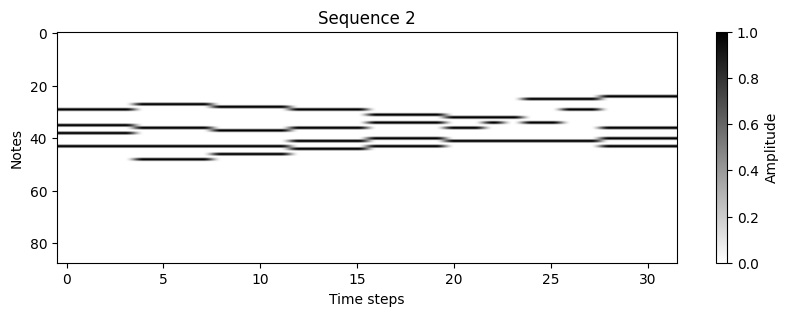

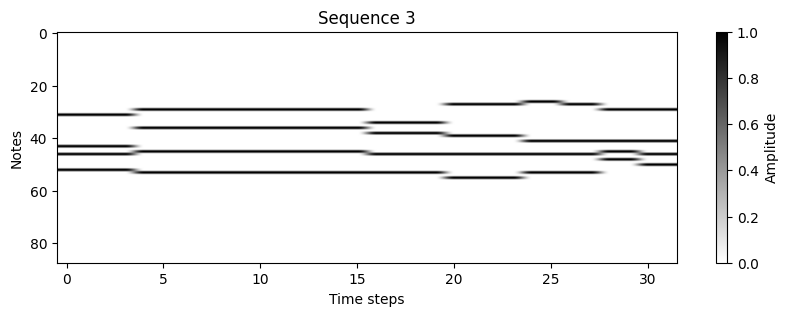

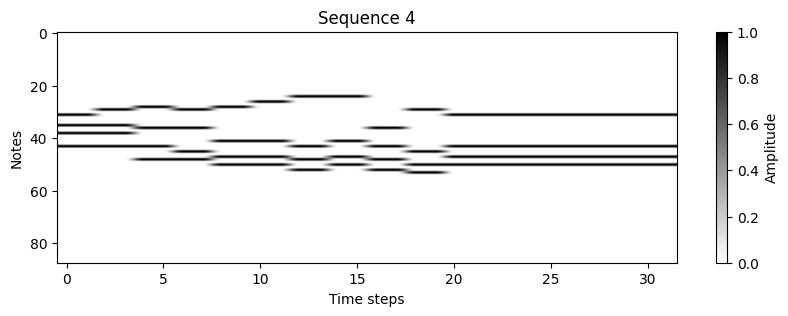

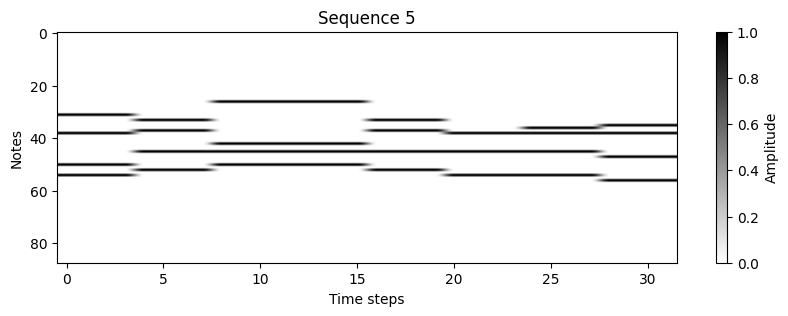

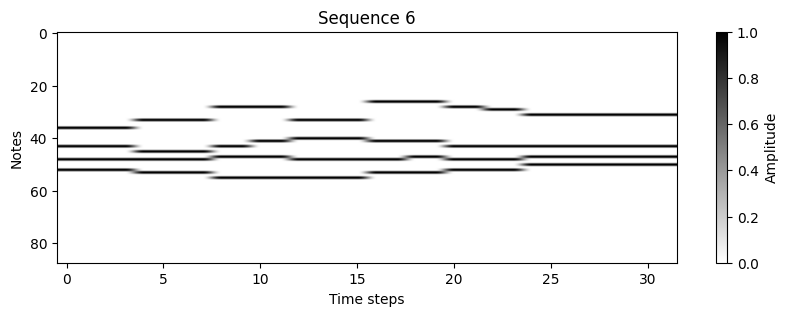

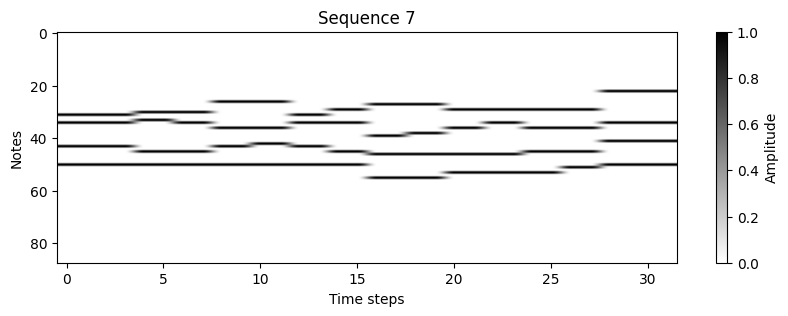

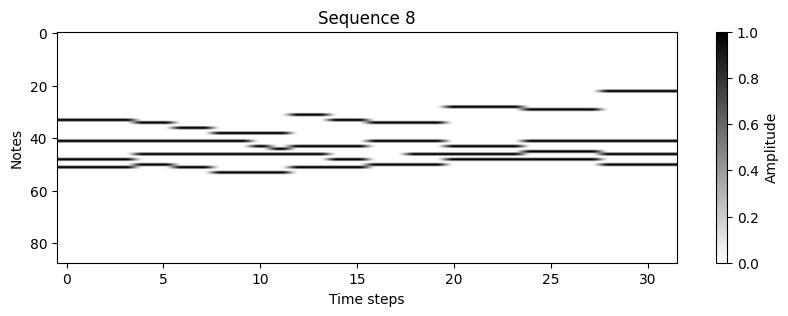

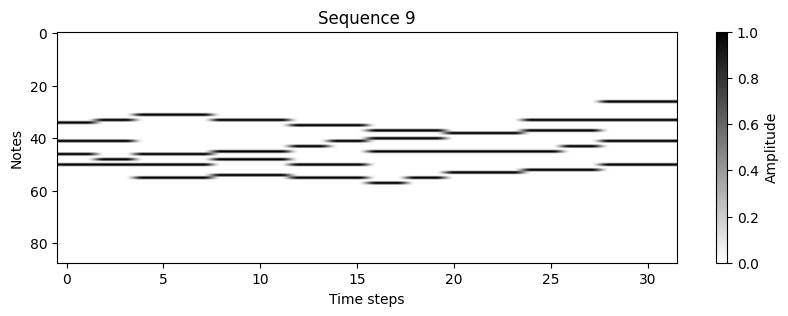

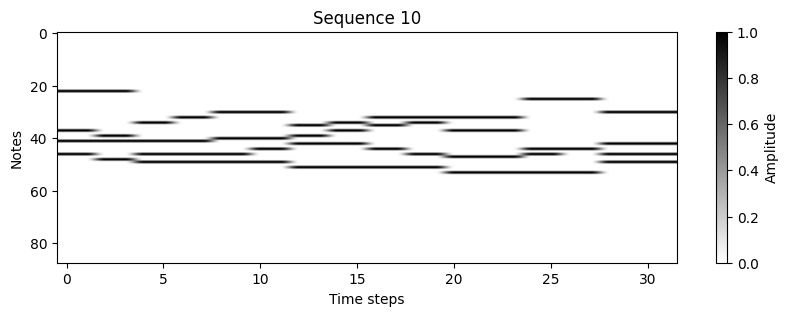

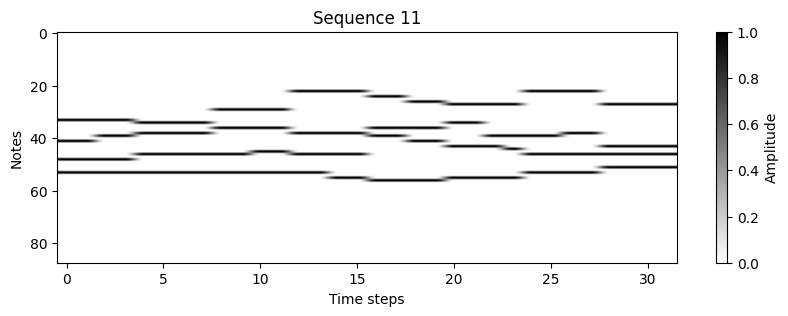

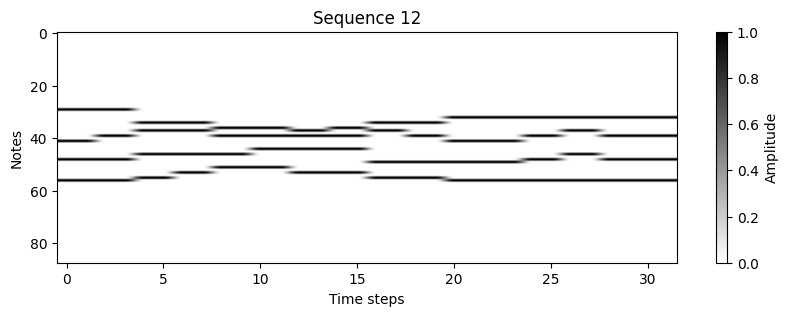

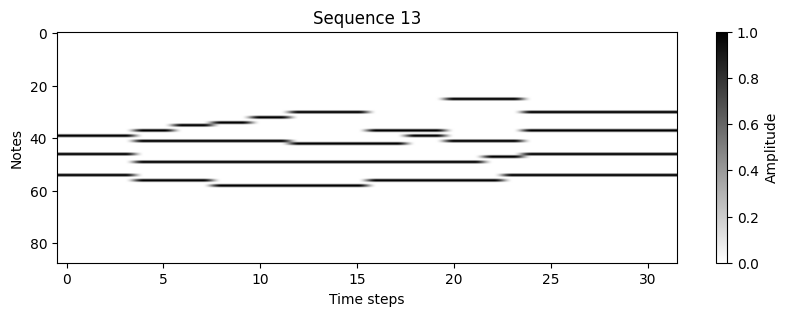

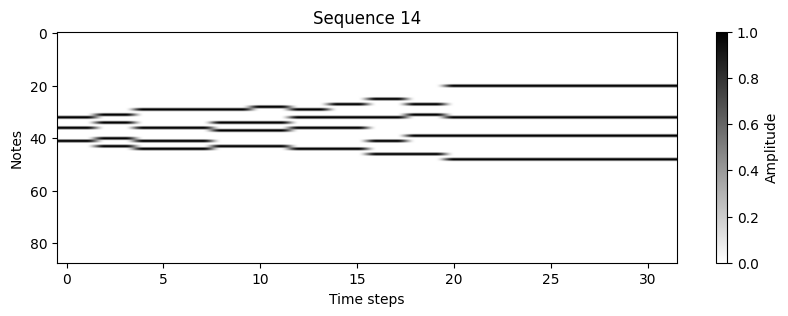

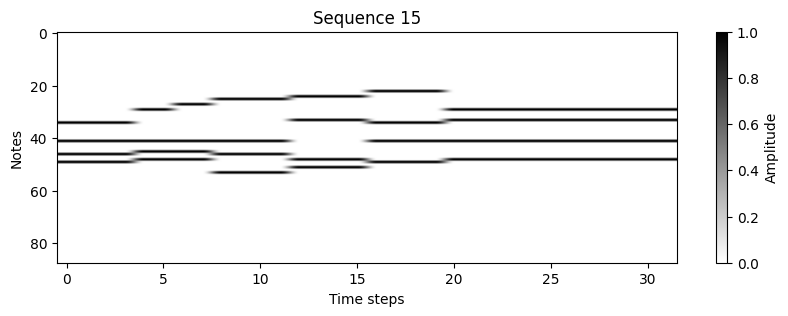

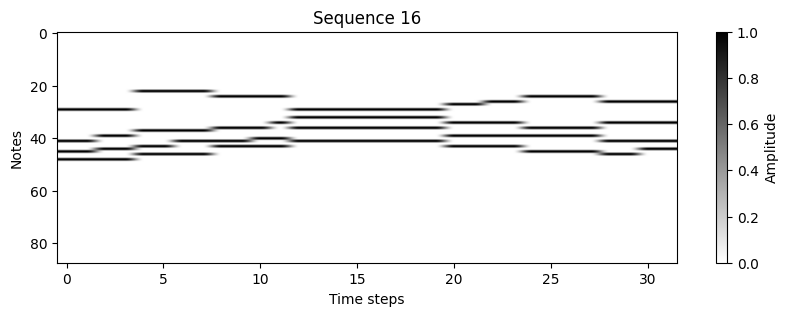

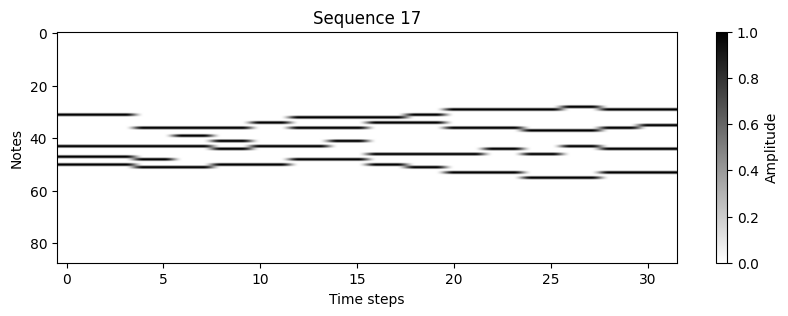

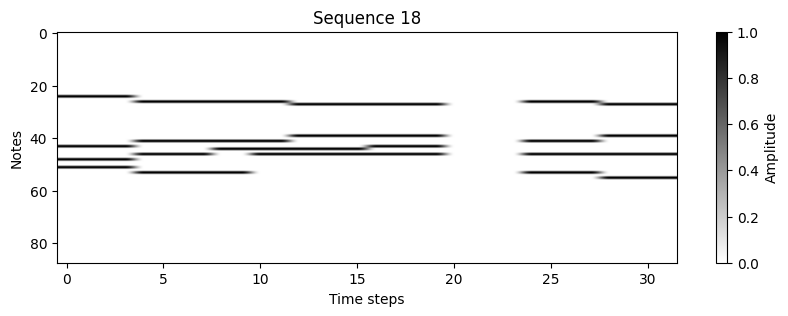

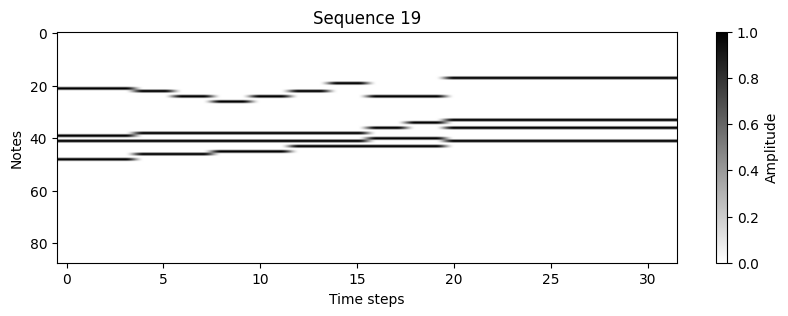

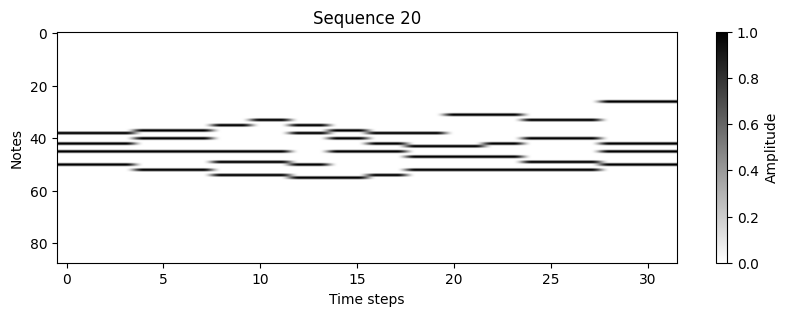

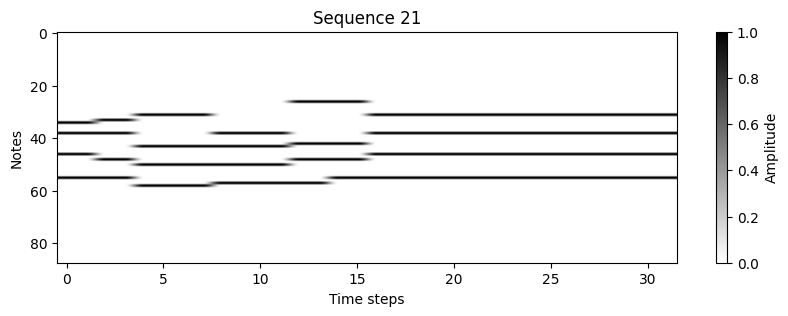

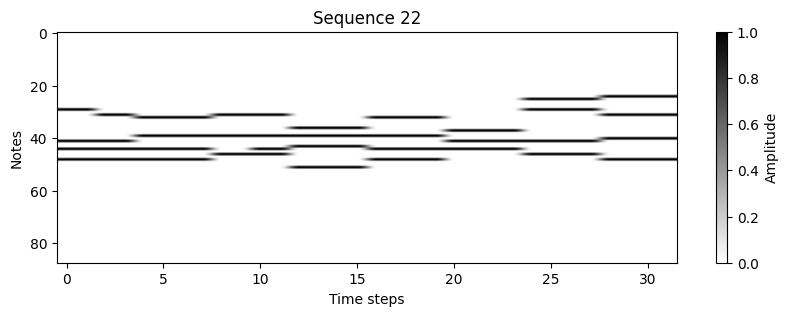

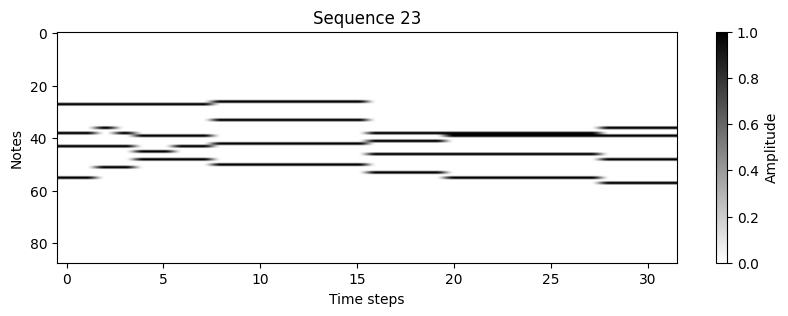

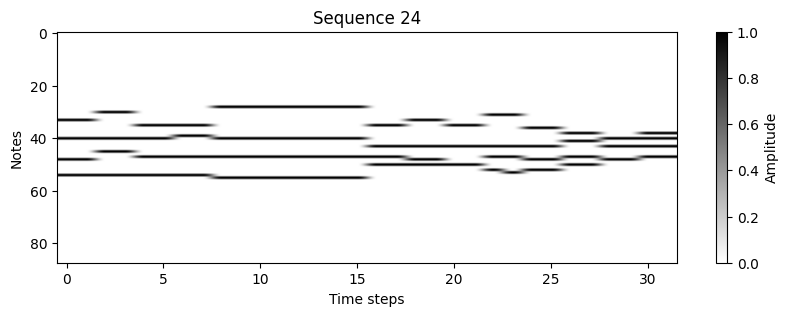

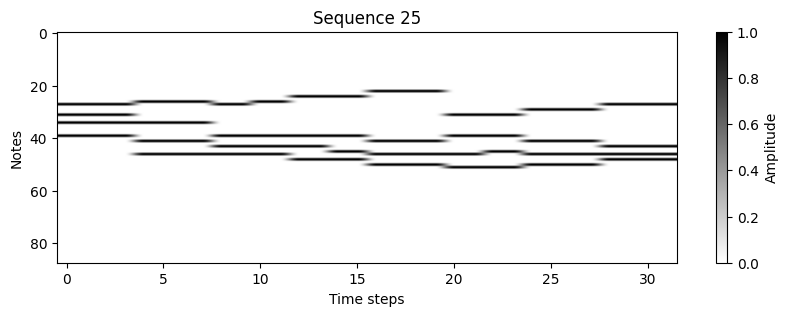

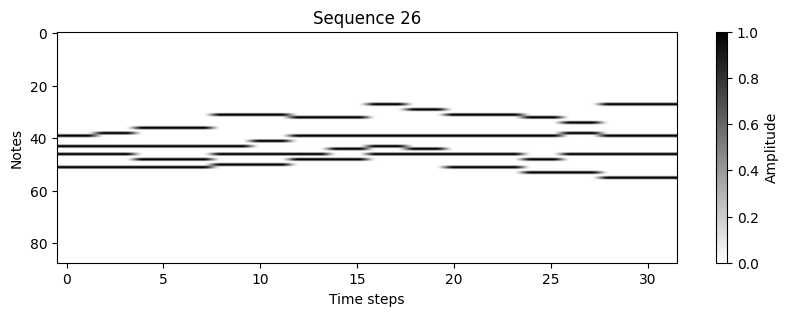

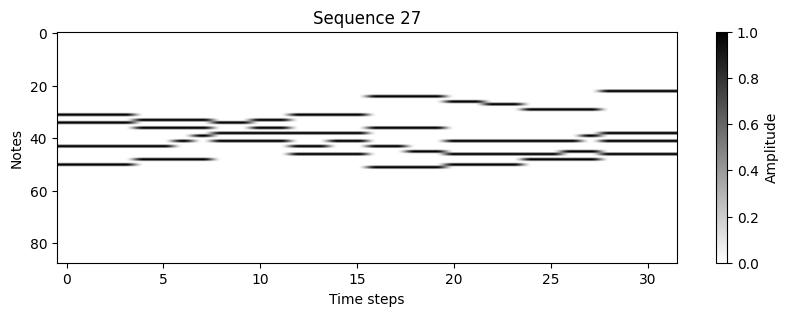

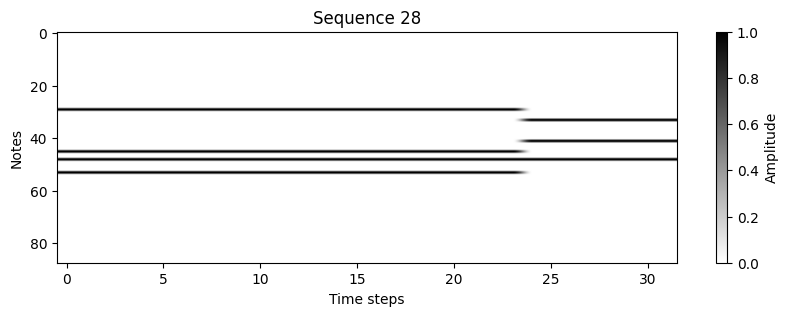

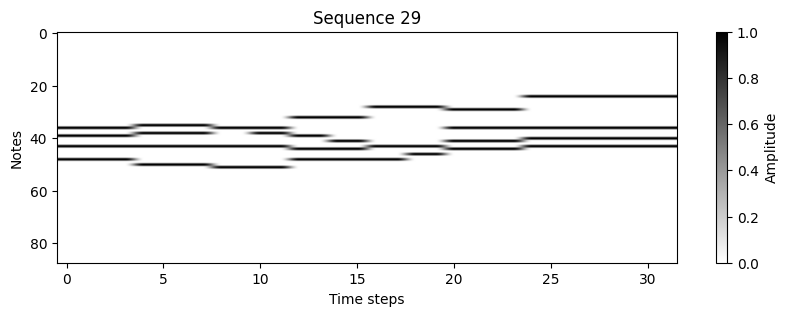

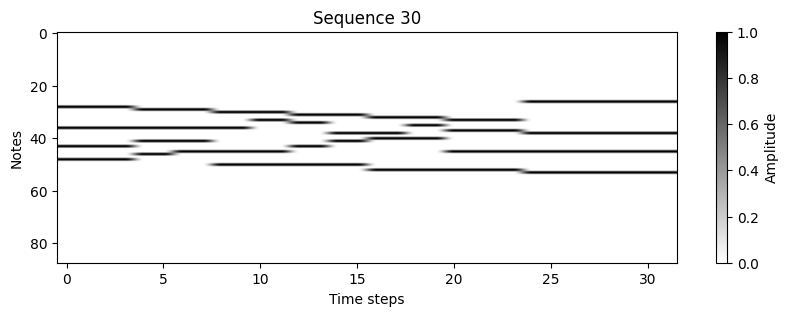

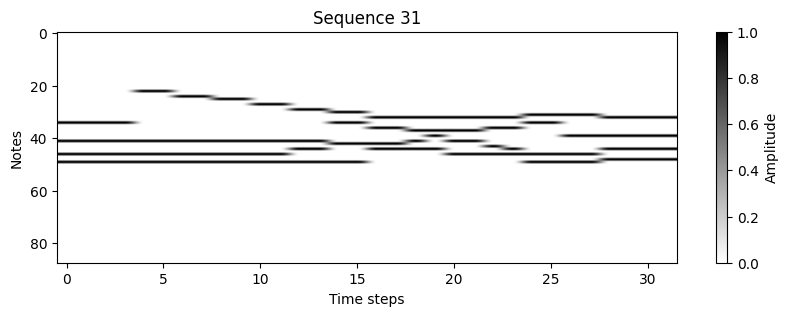

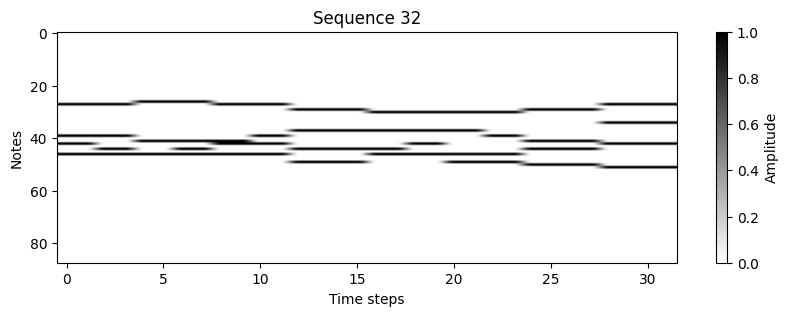

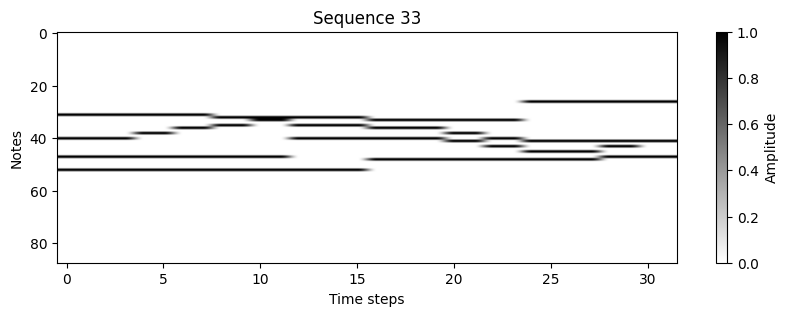

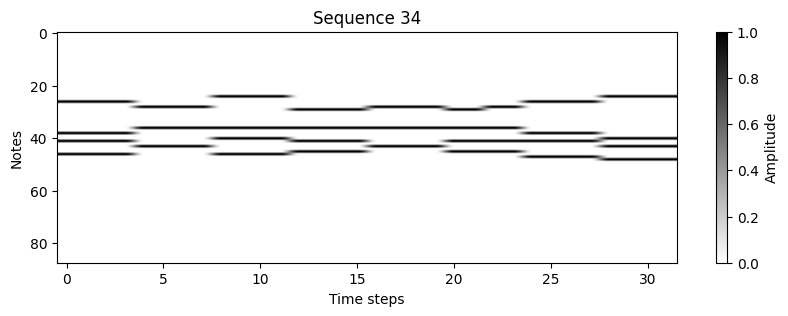

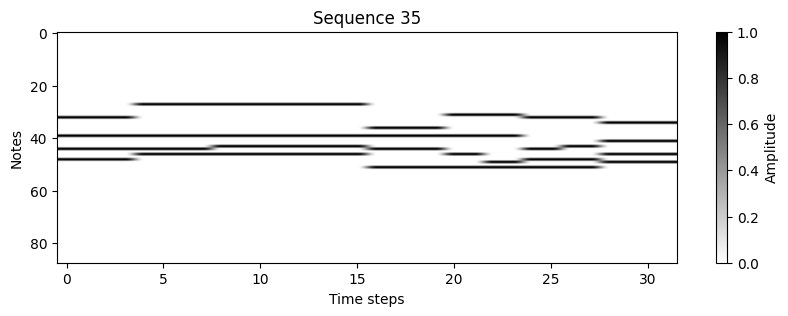

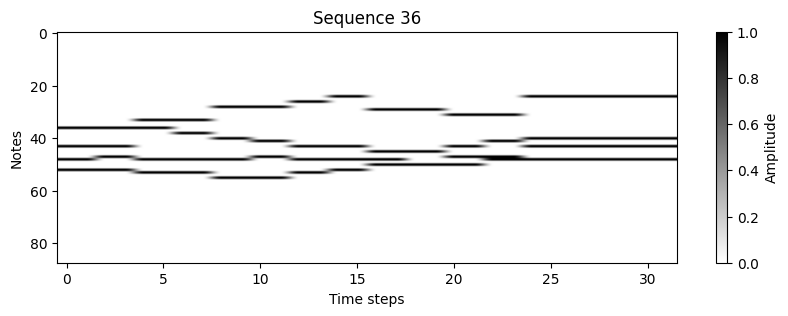

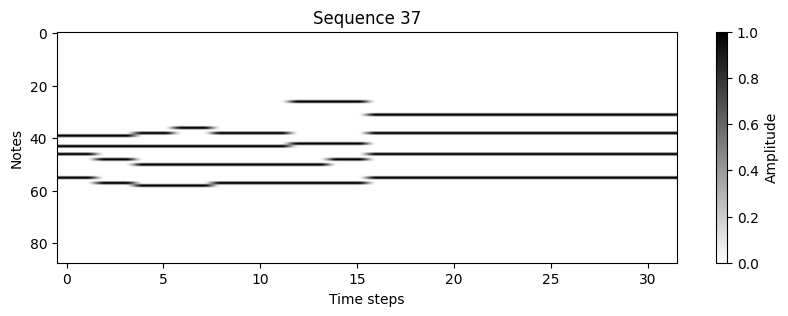

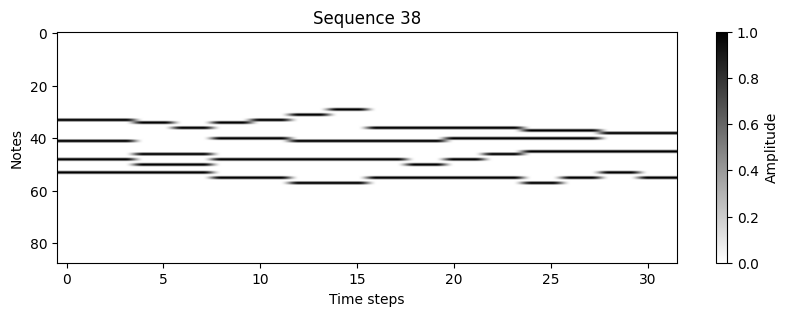

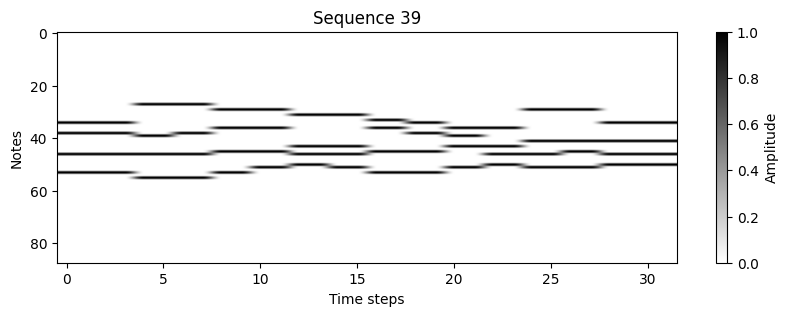

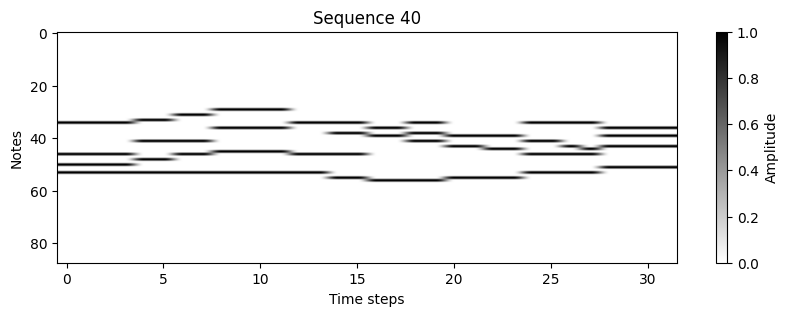

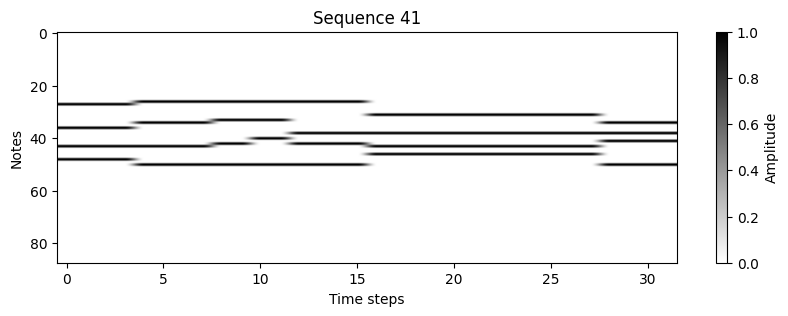

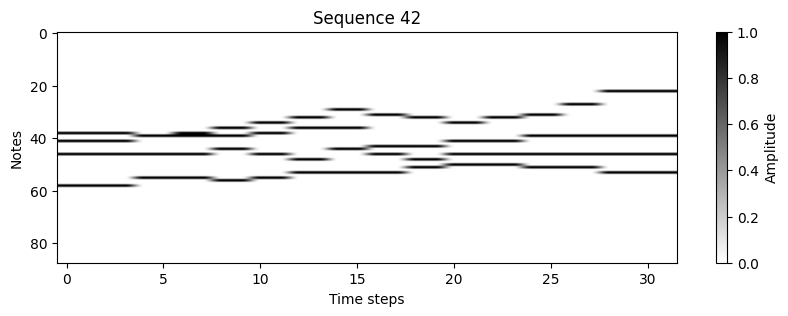

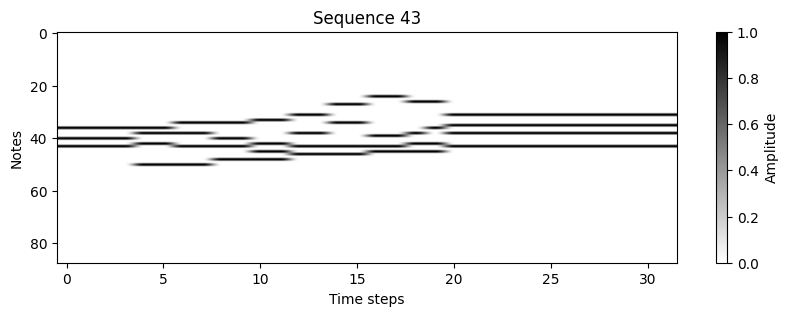

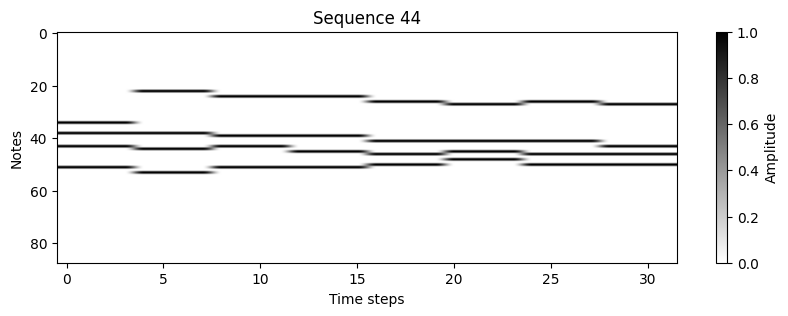

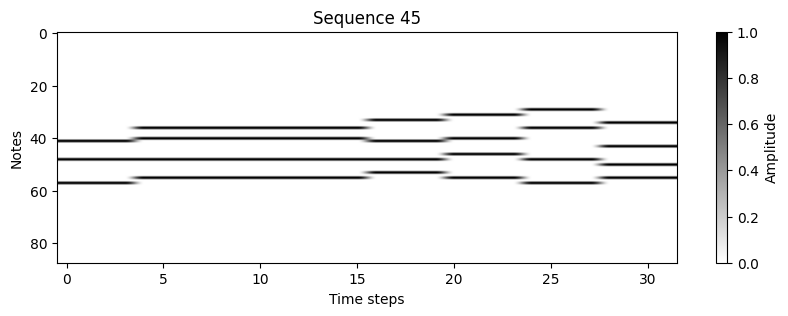

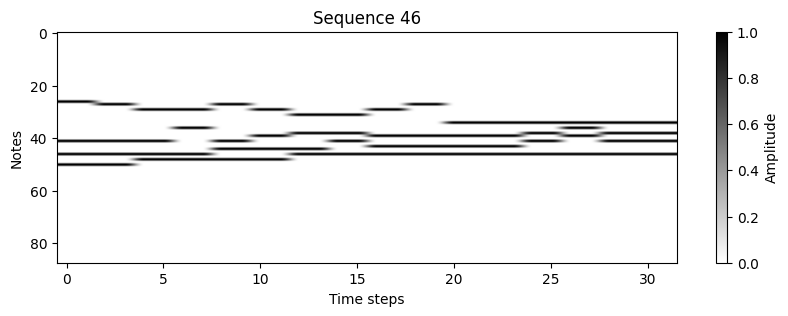

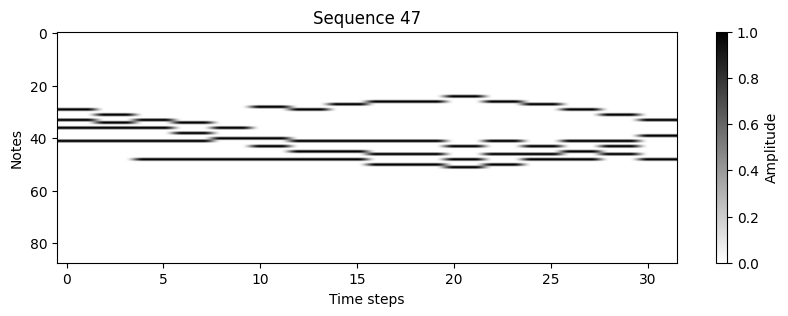

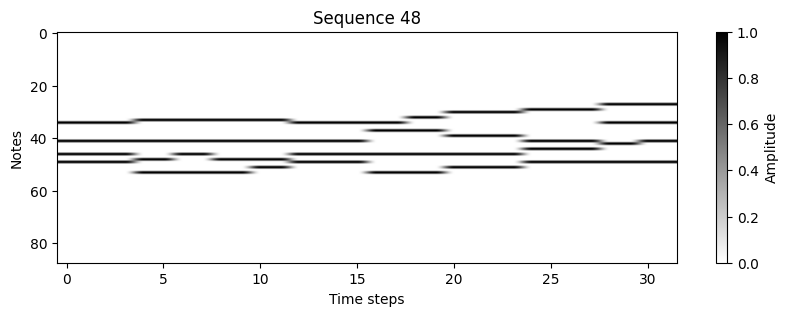

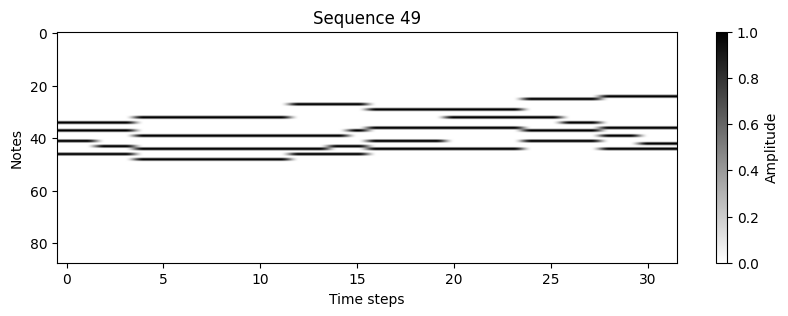

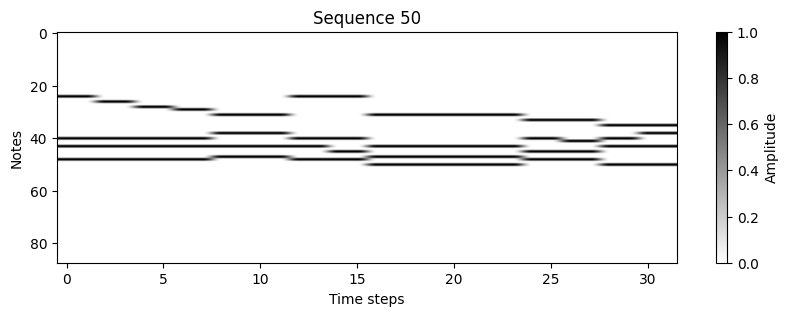

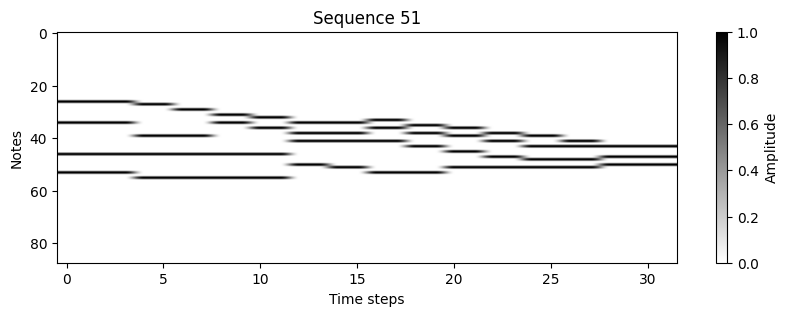

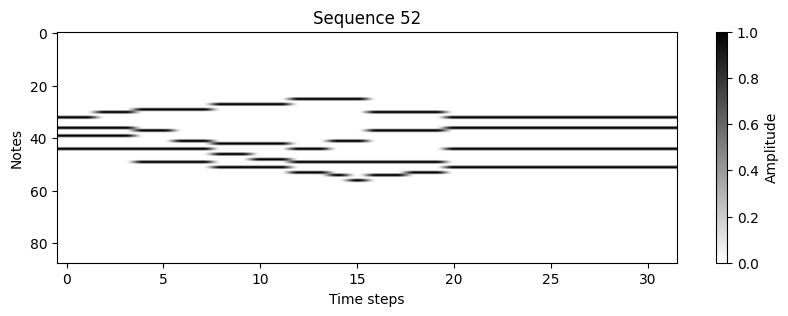

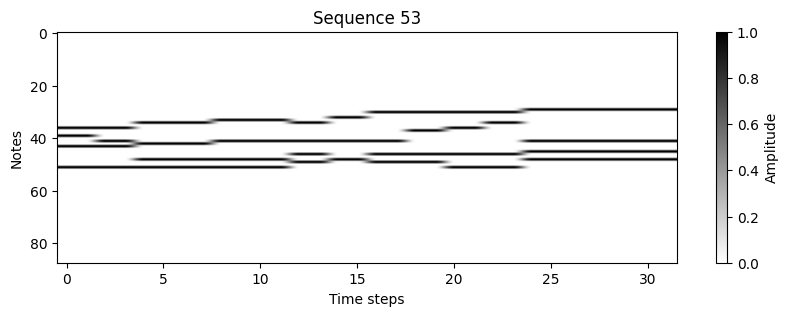

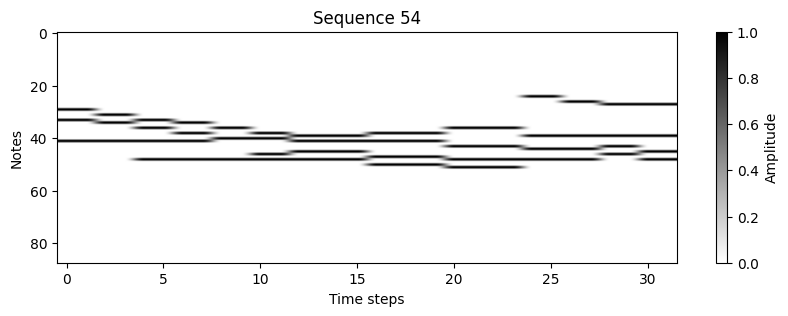

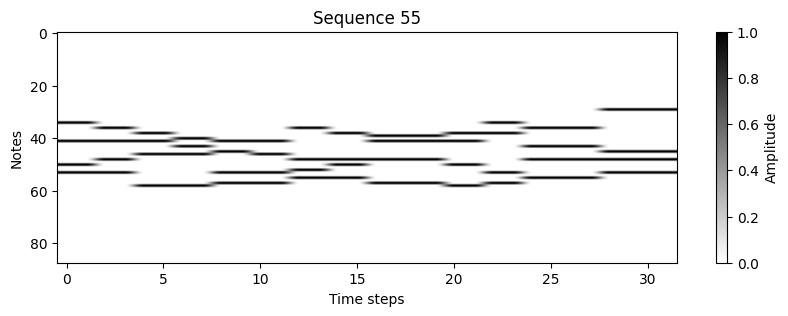

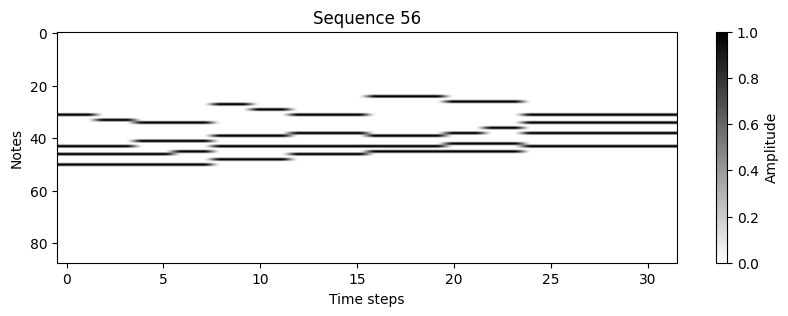

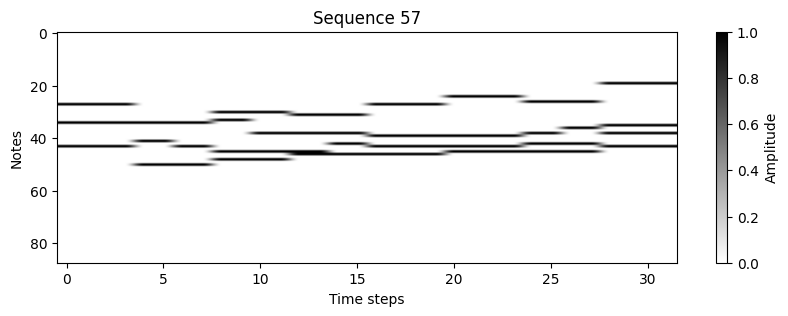

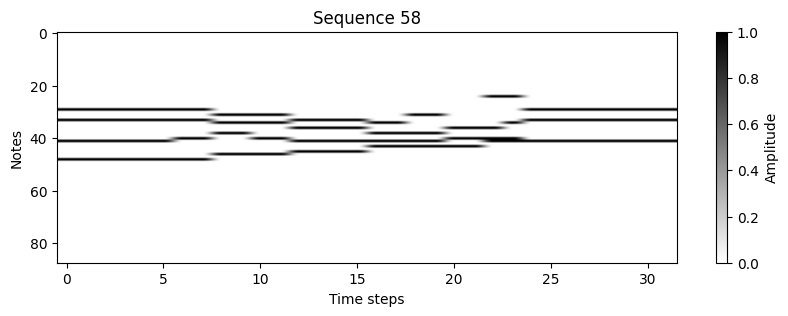

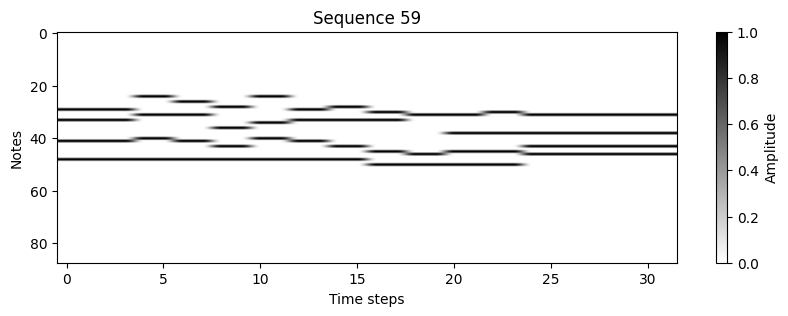

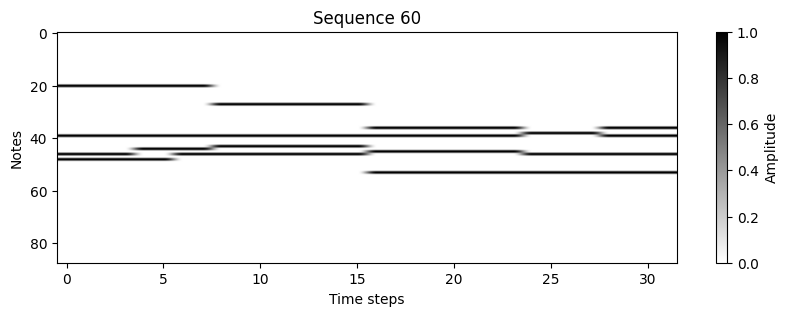

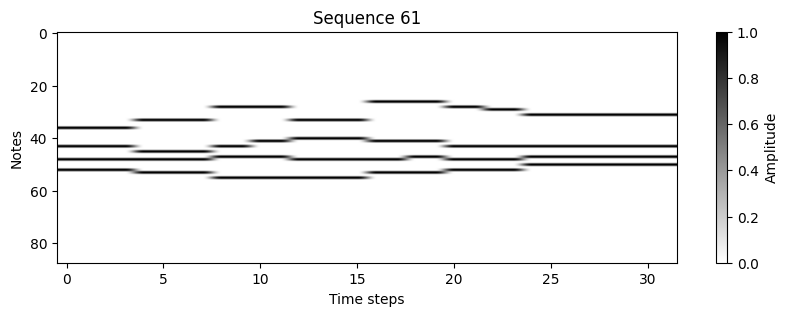

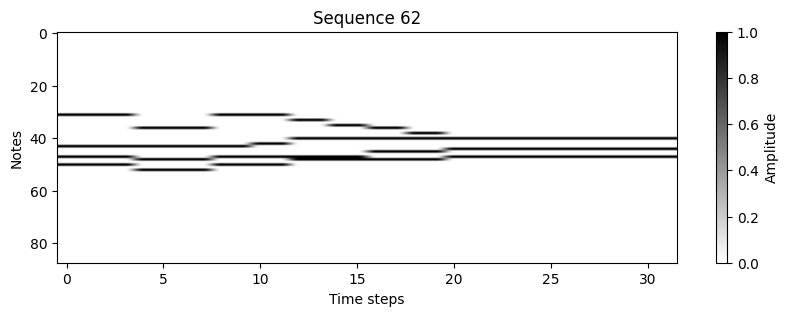

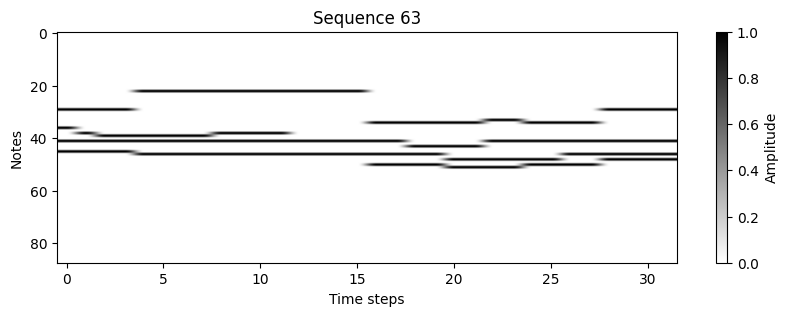

In [ ]:
for batch in train_loader:
    print(batch.shape)
    break

plot_piano_sequences(batch, titles=[f"Sequence {i}" for i in range(batch.shape[0])])



In [ ]:
def plot_piano_roll_comparison(original: torch.Tensor,
                               reconstruction: torch.Tensor,
                               index_sequence: int = 0,
                               title_prefix: str = "Sequence"):
    """
    Compare une séquence originale et sa reconstruction (ou génération) avec heatmaps.

    :param original: séquence originale
    :type original: torch.Tensor
    :param reconstruction: séquence de reconstruction
    :type reconstruction: torch.Tensor
    :param index_sequence: indice de la séquence à afficher
    :type index_sequence: int
    :param title_prefix: préfixe pour les titres des graphiques
    :type title_prefix: str
    """


    orig_seq = original[index_sequence].T.cpu().numpy()
    recon_seq = reconstruction[index_sequence].T.cpu().numpy()
    diff_seq = np.abs(orig_seq - recon_seq)

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    im0 = axes[0].imshow(orig_seq, origin='lower', aspect='auto', cmap='gray_r', interpolation='nearest')
    axes[0].set_title(f"{title_prefix} - Original")
    axes[0].set_xlabel("Time step")
    axes[0].set_ylabel("MIDI Note")
    fig.colorbar(im0, ax=axes[0], orientation='vertical', shrink=0.9)

    im1 = axes[1].imshow(recon_seq, origin='lower', aspect='auto', cmap='gray_r', interpolation='nearest')
    axes[1].set_title(f"{title_prefix} - Reconstruction")
    axes[1].set_xlabel("Time step")
    axes[1].set_ylabel("MIDI Note")
    fig.colorbar(im1, ax=axes[1], orientation='vertical', shrink=0.9)

    im2 = axes[2].imshow(diff_seq, origin='lower', aspect='auto', cmap='Reds', interpolation='nearest')
    axes[2].set_title(f"{title_prefix} - Difference")
    axes[2].set_xlabel("Time step")
    axes[2].set_ylabel("MIDI Note")
    fig.colorbar(im2, ax=axes[2], orientation='vertical', shrink=0.9)

    plt.tight_layout()
    plt.show()


#### Creation of STORN

In [ ]:
from typing import OrderedDict


class PositionalEncoding(nn.Module):
    """Positional encoding """
    def __init__(self, d_model : int, max_len : int=5000):
      """
      Initialisation du postional encoding

      :param d_model: dimension du modèle
      :type d_model: int
      :param max_len: longueur maximale de la séquence
      :type max_len: int
      """
      super().__init__()
      pe = torch.zeros(max_len, d_model)
      position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
      div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
      pe[:, 0::2] = torch.sin(position * div_term)
      pe[:, 1::2] = torch.cos(position * div_term)
      pe = pe.unsqueeze(0)
      self.register_buffer('pe', pe)

    def forward(self, x):
      """
      Exécution d'un positional encoding

      :param x:
      :type x: torch.Tensor
      :return:  Positional encoding
      :rtype: torch.Tensor
      """
      return x + self.pe[:, :x.size(1), :]

class Encoder(nn.Module):
    '''
    Prend la séquence x(t) et renvoie les paramètres mu(phi) et v(phi)
    '''
    def __init__(self, dim_x=88,
                 dim_g=128,
                 dim_z=16,
                 activation = "tanh",
                 dense_x_g=[128],
                 dense_g_z=[128],
                 dim_RNN_g=128,
                 num_RNN_g=1,
                 dropout_p=0,
                 nhead=16,
                 num_transformer_layers=4,
                 embedding_dim=32,
                 encoder_type="rnn",):
      """
      Initialisation de l'encoder

      :param: dim_x: dimension de x
      :type: dim_x: int
      :param: dim_g: dimension de g
      :type: dim_g: int
      :param: dim_z: dimension de z
      :type: dim_z: int
      :param: activation: fonction d'activation
      :type: activation: str
      :param: dense_x_g: liste de dimensions de la couche dense de x vers g
      :type: dense_x_g: list
      :param: dense_g_z: liste de dimensions de la couche dense de g vers z
      :type: dense_g_z: list
      :param: dim_RNN_g: dimension de la couche RNN de g
      :type: dim_RNN_g: int
      :param: num_RNN_g: nombre de couches RNN de g
      :type: num_RNN_g: int
      :param: dropout_p: probabilité de dropout
      :type: dropout_p: float
      :param: nhead: nombre de têtes d'attention
      :type: nhead: int
      :param: num_transformer_layers: nombre de couches transformer
      :type: num_transformer_layers: int
      :param: embedding_dim: dimension de l'embedding
      :type: embedding_dim: int
      :param: encoder_type: type d'encoder
      :type: encoder_type: str
      """

      super(Encoder, self).__init__()

      # Paramètres de l'encoder
      self.dim_x = dim_x
      self.dim_z = dim_z
      self.dim_g = dim_g
      self.dropout_p = dropout_p
      self.encoder_type = encoder_type.lower()

      if activation == "relu" :
        self.activation = nn.ReLU()
      elif activation == "tanh" :
        self.activation = nn.Tanh()
      else:
        raise ValueError("Wrong activition")

      # Paramètres DNN et RNN
      self.dense_x_g = dense_x_g
      self.dense_g_z = dense_g_z
      self.dim_RNN_g = dim_RNN_g
      self.num_RNN_g = num_RNN_g


      # x_t vers g_t
      dic_layers = OrderedDict()
      if len(self.dense_x_g) == 0 :
        dim_x_g = dim_x
        dic_layers["Identity"] = nn.Identity()
      else:
        dim_x_g = self.dense_x_g[-1]
        for n in range(len(self.dense_x_g)) :
          if n ==0 :
            dic_layers['linear'+str(n)] = nn.Linear(dim_x, self.dense_x_g[n])
          else:
            dic_layers['linear'+str(n)] = nn.Linear(self.dense_x_g[n-1], self.dense_x_g[n])
          dic_layers['activation'+str(n)] = self.activation
          dic_layers['dropout'+str(n)] = nn.Dropout(p=self.dropout_p)
      self.mlp_x_g = nn.Sequential(dic_layers)

      # RNN or Transformers:

      # Bloc séquentiel
      if self.encoder_type == "rnn":
          self.sequence_model = nn.GRU(
              input_size=dim_x_g,
              hidden_size=dim_RNN_g,
              num_layers=num_RNN_g,
              batch_first=True
          )
          self.seq_output_dim = dim_RNN_g

      elif self.encoder_type == "transformer":
          self.pos_encoder = PositionalEncoding(d_model=dim_x_g)
          encoder_layer = nn.TransformerEncoderLayer(
              d_model=dim_x_g,
              nhead=nhead,
              dim_feedforward=dim_RNN_g,
              dropout=dropout_p,
              activation="relu"
              )
          self.sequence_model = nn.TransformerEncoder(encoder_layer, num_layers=num_transformer_layers)
          self.seq_output_dim = dim_x_g
      else:
          raise ValueError("encoder_type must be 'rnn' or 'transformer'")

      # MLP g vers z:
      dic_layers = OrderedDict()
      if len(dense_g_z) == 0:
          dim_g_z = self.seq_output_dim
          dic_layers["Identity"] = nn.Identity()
      else:
          dim_g_z = dense_g_z[-1]
          for n in range(len(dense_g_z)):
              in_dim = self.seq_output_dim if n == 0 else dense_g_z[n-1]
              dic_layers[f'linear{n}'] = nn.Linear(in_dim, dense_g_z[n])
              dic_layers[f'activation{n}'] = self.activation
              dic_layers[f'dropout{n}'] = nn.Dropout(p=dropout_p)
      self.mlp_g_z = nn.Sequential(dic_layers)

      self.inf_mean   = nn.Linear(dim_g_z, self.dim_z)
      self.inf_logvar = nn.Linear(dim_g_z, self.dim_z)

    def forward(self, x : np.ndarray):
      """
      Passage de l'encodeur sur les données x

      :param x: données d'entrée
      :type x: torch.Tensor

      :return: mu_phi, v_phi, z les
      :rtype: torch.Tensor
      """
      B, T, dim_x = x.shape

      x_tilde = self.mlp_x_g(x)

      # RNN ou Transformer
      if self.encoder_type == "rnn":
        g, _ = self.sequence_model(x_tilde)
      elif self.encoder_type == "transformer":

        x_tilde = self.pos_encoder(x_tilde)

        h_t = x_tilde.permute(1,0,2)
        g_t = self.sequence_model(h_t)
        g = g_t.permute(1,0,2)

      g_flat = g.reshape(B*T, g.shape[2])
      raw_output = self.mlp_g_z(g_flat)
      mu_phi_flat = self.inf_mean(raw_output)
      v_phi_flat = self.inf_logvar(raw_output)

      std_phi_flat = torch.exp(0.5*v_phi_flat)
      eps = torch.rand_like(std_phi_flat)
      z_flat = mu_phi_flat + std_phi_flat * eps

      mu_phi = mu_phi_flat.reshape(B, T, self.dim_z)
      v_phi = v_phi_flat.reshape(B, T, self.dim_z)
      z = z_flat.reshape(B, T, self.dim_z)

      return mu_phi, v_phi,z


In [ ]:
class Decoder(nn.Module):
    '''
    Prend la séquence z(t) et renvoie les paramètres mu(theta) et v(theta)
    '''
    def __init__(self, dim_x=88,
                 dim_z=16,
                 dim_h=128,
                 dim_x_tilde = 32,
                 activation = "tanh",
                 dense_z_h=[128],
                 dense_xtilde_h=[128],
                 dense_h_x=[128],
                 dim_RNN_h=128,
                 num_RNN_h=1,
                 dropout_p=0,
                 nhead=16,
                 num_transformer_layers=4,
                 embedding_dim=32,
                 decoder_type="rnn"):
      """
      Initialisation du décodeur

      :param: dim_x: dimension de x
      :type: dim_x: int
      :param: dim_z: dimension de z
      :type: dim_z: int
      :param: dim_h: dimension de h
      :type: dim_h: int
      :param: dim_x_tilde: dimension de x_tilde
      :type: dim_x_tilde: int
      :param: activation: fonction d'activation
      :type: activation: str
      :param: dense_z_h: liste de dimensions de la couche dense de z vers h
      :type: dense_z_h:
      :param: dense_xtilde_h: liste de dimensions de la couche dense de x_tilde vers h
      :type: dense_xtilde_h
      :param: dense_h_x: liste de dimensions de la couche dense de h vers x
      :type: dense_h_x
      :param: dim_RNN_h: dimension de la couche RNN de h
      :type: dim_RNN_h
      :param: num_RNN_h: nombre de couches RNN de h
      :type: num_RNN_h
      :param: dropout_p: probabilité de dropout
      :type: dropout_p
      :param: nhead: nombre de têtes d'attention
      :type: nhead
      :param: num_transformer_layers: nombre de couches transformer
      :type: num_transformer_layers
      :param: embedding_dim: dimension de l'embedding
      :type: embedding_dim
      :param: decoder_type: type de décodeur
      :type: decoder_type

      """

      super(Decoder, self).__init__()

      # Paramètre générale
      self.dim_x = dim_x
      self.dim_y = dim_x
      self.dim_z = dim_z
      self.dim_h = dim_h
      self.dropout_p = dropout_p
      self.decoder_type = decoder_type
      self.dim_x_tilde = dim_x_tilde
      if activation == "relu" :
        self.activation = nn.ReLU()
      elif activation == "tanh" :
        self.activation = nn.Tanh()
      else:
        raise ValueError("Wrong activition")

      # Paramètre Decoder
      self.dense_z_h = dense_z_h
      self.dense_h_x = dense_h_x
      self.dim_RNN_h = dim_RNN_h
      self.num_RNN_h = num_RNN_h
      self.dense_xtilde_h = dense_xtilde_h


      dic_layers = OrderedDict()
      if len(self.dense_z_h) == 0:
          dim_z_h = self.dim_z
          dic_layers['Identity'] = nn.Identity()
      else:
          dim_z_h = self.dense_z_h[-1]
          for n in range(len(self.dense_z_h)):
              if n == 0:
                  dic_layers['linear'+str(n)] = nn.Linear(self.dim_z, self.dense_z_h[n])
              else:
                  dic_layers['linear'+str(n)] = nn.Linear(self.dense_z_h[n-1], self.dense_z_h[n])
              dic_layers['activation'+str(n)] = self.activation
              dic_layers['dropout'+str(n)] = nn.Dropout(p=self.dropout_p)
      self.mlp_z_h = nn.Sequential(dic_layers)

      # MLP x vers x_tilde:
      dic_layers = OrderedDict()
      if len(self.dense_xtilde_h) == 0:
          dim_x_tilde = self.dim_x
          dic_layers['Identity'] = nn.Identity()
      else:
          dim_x_tilde = self.dense_xtilde_h[-1]
          for n in range(len(self.dense_xtilde_h)):
              if n == 0:
                  dic_layers['linear'+str(n)] = nn.Linear(self.dim_x, self.dense_xtilde_h[n])
              else:
                  dic_layers['linear'+str(n)] = nn.Linear(self.dense_xtilde_h[n-1], self.dense_xtilde_h[n])
              dic_layers['activation'+str(n)] = self.activation
              dic_layers['dropout'+str(n)] = nn.Dropout(p=self.dropout_p)
      self.mlp_x_x_tilde = nn.Sequential(dic_layers)


      # Bloc séquentiel
      if self.decoder_type == "rnn":
          self.sequence_model = nn.GRUCell(dim_z_h+dim_x_tilde, dim_h, self.num_RNN_h)
          self.seq_output_dim = dim_h

      elif self.decoder_type == "transformer":
          self.pos_encoder = PositionalEncoding(d_model=dim_z_h+dim_x_tilde)
          encoder_layer = nn.TransformerEncoderLayer(
              d_model=dim_z_h+dim_x_tilde,
              nhead=nhead,
              dim_feedforward=dim_RNN_h,
              dropout=dropout_p,
              activation="relu"
              )
          self.sequence_model = nn.TransformerEncoder(encoder_layer, num_layers=num_transformer_layers)
          self.seq_output_dim = dim_z_h+dim_x_tilde
      else:
          raise ValueError("decoder_type must be 'rnn' or 'transformer'")


      # MLP h vers y:
      dic_layers = OrderedDict()
      if len(self.dense_h_x) == 0:
          dim_h_x = self.seq_output_dim
          dic_layers['Identity'] = nn.Identity()
      else:
          dim_h_x = self.dense_h_x[-1]
          for n in range(len(self.dense_h_x)):
              if n == 0:
                  dic_layers['linear'+str(n)] = nn.Linear(self.seq_output_dim, self.dense_h_x[n])
              else:
                  dic_layers['linear'+str(n)] = nn.Linear(self.dense_h_x[n-1], self.dense_h_x[n])
              dic_layers['activation'+str(n)] = self.activation
              dic_layers['dropout'+str(n)] = nn.Dropout(p=self.dropout_p)
      dic_layers["out"] =  nn.Linear(dim_h_x, self.dim_y)
      self.mlp_h_y = nn.Sequential(dic_layers)

    def forward(self, z):
      """
      Exécution du décodeur pour un passage

      :param z: séquence de z
      :type z: torch.Tensor
      """
      B, T, _ = z.shape
      device = z.device

      x_prev_t = torch.zeros(B,self.dim_x, device=device)
      h_t = torch.zeros(B, self.dim_h, device=device)

      if self.decoder_type == "rnn":
          x_prev = torch.zeros(B, self.dim_x, device=device)
          h = torch.zeros(B, self.dim_h, device=device)
          outputs = []

          for t in range(T):
              z_t = z[:, t, :]
              z_tilde = self.mlp_z_h(z_t)
              x_tilde = self.mlp_x_x_tilde(x_prev)
              rnn_input = torch.cat([z_tilde, x_tilde], dim=1)
              h = self.sequence_model(rnn_input, h)
              x_prev = self.mlp_h_y(h)
              outputs.append(x_prev)

          output = torch.stack(outputs, dim=1)
          return output

      elif self.decoder_type == "transformer":
          z_tilde = self.mlp_z_h(z)
          x_init = torch.zeros(B, T, self.dim_x, device=device)
          x_tilde = self.mlp_x_x_tilde(x_init)
          seq_input = torch.cat([z_tilde, x_tilde], dim=-1)
          seq_input = self.pos_encoder(seq_input)
          seq_input = seq_input.transpose(0,1)
          h_seq = self.sequence_model(seq_input)
          h_seq = h_seq.transpose(0,1)
          output = self.mlp_h_y(h_seq)
          return output

def next(self, z, x_seed):
    """
    Prochain pour le RNN

    :param z: séquence de z
    :type z: torch.Tensor
    :param x_seed: séquence de x
    :type x_seed: torch.Tensor
    """
    if self.decoder_type != "rnn":
        raise NotImplementedError("next() is only implemented for RNN decoder")
    B, T, _ = z.shape
    device = z.device

    x_prev = x_seed
    h = torch.zeros(B, self.dim_h, device=device)
    outputs = []

    for t in range(T):
        z_t = z[:, t, :]
        z_tilde = self.mlp_z_h(z_t)
        x_tilde = self.mlp_x_x_tilde(x_prev)
        rnn_input = torch.cat([z_tilde, x_tilde], dim=1)
        h = self.sequence_model(rnn_input, h)
        x_prev = self.mlp_h_y(h)
        outputs.append(x_prev)

    output = torch.stack(outputs, dim=1)
    return output

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

class Storn(nn.Module):
    """
    Modèle complet Storn
    """
    def __init__(self,
                 dim_x=88,
                 dim_z=16,
                 dim_h=128,
                 dim_x_tilde=32,
                 dense_z_h=[128],
                 dense_xtilde_h=[128],
                 dense_h_x=[128],
                 dim_RNN_h=128,
                 dim_g=128,
                 dense_x_g=[128],
                 dense_g_z=[128],
                 dim_RNN_g=128,
                 num_RNN_g=1,
                 activation="tanh",
                 num_RNN_h=1,
                 dropout_p=0,
                 encoder_type="rnn",
                 decoder_type="rnn"):
        """
        Initialisation du modèle Storn

        :param dim_x: dimension de x
        :param dim_z: dimension de z
        :param dim_h: dimension de h
        :param dim_x_tilde: dimension de x_tilde
        :param dense_z_h: liste de dimensions de la couche dense de z vers h
        :param dense_xtilde_h: liste de dimensions de la couche dense de x_tilde vers h
        :param dense_h_x: liste de dimensions de la couche dense de h vers x
        :param dim_RNN_h: dimension de la couche RNN de h
        :param dim_g: dimension de g
        :param dense_x_g: liste de dimensions de la couche dense de x vers g
        :param dense_g_z: liste de dimensions de la couche dense de g vers z
        :param dim_RNN_g: dimension de la couche RNN de g
        :param num_RNN_g: nombre de couches RNN de g
        :param activation: fonction d'activation
        :param num_RNN_h: nombre de couches RNN de h
        :param dropout_p: probabilité de dropout
        :param encoder_type: type d'encodeur
        :param decoder_type: type de décodeur
        """
        super(Storn, self).__init__()

        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"Using device: {self.device}\n")

        # Création de l'encodeur
        self.encoder = Encoder(dim_x=dim_x,
                               dim_g=dim_g,
                               dim_z=dim_z,
                               activation=activation,
                               dense_x_g=dense_x_g,
                               dense_g_z=dense_g_z,
                               dim_RNN_g=dim_RNN_g,
                               num_RNN_g=num_RNN_g,
                               dropout_p=dropout_p,
                               encoder_type=encoder_type).to(self.device)
        # Création du décodeur
        self.decoder = Decoder(dim_x=dim_x,
                               dim_z=dim_z,
                               dim_h=dim_h,
                               dim_x_tilde=dim_x_tilde,
                               activation=activation,
                               dense_z_h=dense_z_h,
                               dense_xtilde_h=dense_xtilde_h,
                               dense_h_x=dense_h_x,
                               dim_RNN_h=dim_RNN_h,
                               num_RNN_h=num_RNN_h,
                               dropout_p=dropout_p,
                               decoder_type=decoder_type).to(self.device)

        self.encoder_type = encoder_type
        self.decoder_type = decoder_type

    def forward(self, x):
        """
        Passage de l'encodeur sur les données x

        :param x: données d'entrée
        :type x: torch.Tensor
        """
        mu_phi, v_phi, z = self.encoder(x)
        y = self.decoder(z)

        return y, z, mu_phi, v_phi

    def loss_KLD(self, mu_phi, v_phi) -> torch.Tensor:
        """
        Calcule la loss de la divergence de Kullback-Leibler

        :param mu_phi: moyenne de phi
        :type mu_phi: torch.Tensor
        :param v_phi: variance de phi
        :type v_phi: torch.Tensor

        :return: loss de la divergence de Kullback-Leibler
        :rtype: torch.Tensor
        """
        B, T, _ = mu_phi.shape

        mu_phi_flat = mu_phi.reshape(B * T, self.encoder.dim_z)
        v_phi_flat = v_phi.reshape(B * T, self.encoder.dim_z)

        # Clamping v_phi_flat to prevent numerical instability
        v_phi_flat = torch.clamp(v_phi_flat, min=-10.0, max=10.0)

        mu_squared = torch.sum(mu_phi_flat.pow(2), dim=1)
        trace_sigma = torch.sum(torch.exp(v_phi_flat), dim=1)
        log_det_sigma = torch.sum(v_phi_flat, dim=1)

        kld_sample = 0.5 * (mu_squared + trace_sigma - self.encoder.dim_z - log_det_sigma)

        return torch.sum(kld_sample)

    def fit(self, x: torch.Tensor, lr: float = 0.0001, n_epochs: int = 500):
        """
        Entraînement du modèle

        :param x: données d'entrée
        :type x: torch.Tensor
        :param lr: taux d'apprentissage
        :type lr: float
        :param n_epochs: nombre d'epochs
        :type n_epochs: int

        :return: train_losses, kl_losses, recon_losses
        :rtype: list
        """
        # Optimiseur ADAM
        parameters = [p for p in self.parameters() if p.requires_grad]
        optimizer = optim.Adam(parameters, lr=lr)
        fct_loss_reconstruction = nn.MSELoss(reduction='sum')

        # Dataset et batch
        dataset = TensorDataset(x)
        batch_size = 16
        dataloader = DataLoader(
            dataset,
            batch_size=batch_size,
            shuffle=True
        )

        train_losses = []
        kl_losses = []
        recon_losses = []

        for epoch in range(n_epochs):
            self.train()

            total_loss_epoch = 0
            total_kl_epoch = 0
            total_recon_epoch = 0

            for batch_data in dataloader:
                x_batch = batch_data[0].to(self.device)

                y, _, mu_phi, v_phi = self.forward(x_batch)

                loss_KLD = self.loss_KLD(mu_phi, v_phi)
                loss_reconstruction = fct_loss_reconstruction(y, x_batch)

                beta = 0.2
                # Transformers plus rapide à entrainer
                # Pas les même beta pour qu'il se concentre sur le KL ou la reconstruction il faut trouver un équilibre
                # Beta est hyper super important

                loss_tot = loss_reconstruction + beta * loss_KLD

                optimizer.zero_grad()
                loss_tot.backward()
                optimizer.step()

                # accumuler les pertes pour l'epoch
                total_loss_epoch += loss_tot.item()
                total_kl_epoch += loss_KLD.item()
                total_recon_epoch += loss_reconstruction.item()

            # moyenne par batch (ou garder la somme)
            train_losses.append(total_loss_epoch / len(dataloader))
            kl_losses.append(total_kl_epoch / len(dataloader))
            recon_losses.append(total_recon_epoch / len(dataloader))

            if epoch % 2 == 0:
                print(f"Epoch: {epoch} | Train loss: {loss_tot} | KL loss: {loss_KLD} | recon loss: {loss_reconstruction}")

        return train_losses, kl_losses, recon_losses

    def reconstruct(self, x):
        """
        Reconstruit les données x

        :param x: données d'entrée
        :type x: torch.Tensor

        :return: données reconstruites
        :rtype: torch.Tensor
        """
        if len(x.shape) == 2:
            x = x.unsqueeze(0)
        self.eval()
        with torch.inference_mode():
            x = x.to(self.device)
            y, _, _, _ = self.forward(x)
        return y

    def generate(self, T: int = 16):
        """
        Generation de données

        :param T: longueur de la séquence à générer
        :type T: int
        """
        z = torch.randn(1, T, self.encoder.dim_z).to(self.device)
        self.eval()
        with torch.inference_mode():
            y = self.decoder(z)

        return y, z

    def interpole(self, x1: torch.Tensor, x2: torch.Tensor, N_interp: int = 10):
        """
        Interpole les données x1 et x2

        :param x1: données d'entrée 1
        :type x1: torch.Tensor
        :param x2: données d'entrée 2
        :type x2: torch.Tensor
        :param N_interp: nombre de points d'interpolations
        :type N_interp: int

        :return: données interpolées
        :rtype: torch.Tensor
        """
        x1 = x1.to(self.device)
        x2 = x2.to(self.device)
        if len(x1.shape) == 2:
            x1 = x1.unsqueeze(0)
        if len(x2.shape) == 2:
            x2 = x2.unsqueeze(0)
        self.eval()
        with torch.inference_mode():
            z1, _, _ = self.encoder(x1)
            z2, _, _ = self.encoder(x2)

            alpha = torch.linspace(0, 1, N_interp).to(self.device)
            z = torch.lerp(z1, z2, alpha.view(-1, 1, 1))

            y = self.decoder(z)
        return y

    def next(self, x, T=16):
        """
        Prochain pour le RNN

        :param x: données d'entrée
        :type x: torch.Tensor
        :param T: longueur de la séquence à générer
        :type T: int
        """
        if self.decoder_type == "rnn":
            B = x.shape[0]
            z = torch.randn(B, T, self.encoder.dim_z).to(self.device)
            self.eval()
            with torch.inference_mode():
                x = x.to(self.device)
                y = self.decoder.next(z, x)
            return y, z
        else:
            raise NotImplementedError("next() is only implemented for RNN decoder.")

    def loss_ISD(self, x, y):
        y = y + 1e-10
        ret = torch.sum(x / y - torch.log(x / y) - 1)
        return ret

    def save(self, path_to_file):
        """
        Enregistrement du modèle

        :param path_to_file: chemin du fichier
        :type path_to_file: str
        """
        attrs = {}
        attrs['state_dict'] = self.state_dict()
        # NOTE: Vous ne sauvegardez que le state_dict ici, pas les hyperparamètres (dim_x, etc.)
        # Cela posera problème pour la méthode load() ci-dessous.
        torch.save(attrs, path_to_file)
        print("\nModel saved to", path_to_file)

    @classmethod
    def load(cls, path_to_file):
        """
        Chargement du modèle

        :param path_to_file: chemin du fichier
        :type path_to_file: str

        :return: modèle chargé
        :rtype: Storn
        """
        attrs = torch.load(path_to_file, map_location=lambda storage, loc: storage)
        state_dict = attrs.pop('state_dict')

        # ATTENTION: attrs est vide ici si 'save' n'a enregistré que 'state_dict'.
        # Cela va initialiser Storn avec les paramètres par défaut.
        new = cls(**attrs)
        new.load_state_dict(state_dict)
        return new

In [ ]:
# PARAMTRE
dim_x = 88
dim_z = 32

dense_z_h = [128]
dense_xtilde_h = [128]
dense_h_x = [128]

dim_RNN_h = 128 # 256 = KL vanishing

dense_x_g = [128]
dense_g_z = [128]
dim_RNN_g =  128

num_RNN_g = 1



activation = "tanh"
num_RNN_h = 1
dropout_p = 0

In [ ]:
storn_model = Storn(dim_x,
                    dim_z,
                    dense_z_h=dense_z_h,
                    dense_xtilde_h=dense_xtilde_h,
                    dense_h_x = dense_h_x,
                    dim_RNN_h= dim_RNN_h,
                    dense_x_g=dense_x_g,
                    dense_g_z=dense_g_z,
                    dim_RNN_g=dim_RNN_g,
                    num_RNN_g= num_RNN_g,
                    activation=activation,
                    num_RNN_h=num_RNN_h,
                    dropout_p=dropout_p,
                    encoder_type="rnn",
                    decoder_type="rnn")

# Temporarily force CPU to diagnose CUDA error
if 'cuda' in str(storn_model.device): # Check if device was set to CUDA
    print("Switching model to CPU for debugging...")
    storn_model.device = torch.device('cpu') # Override device attribute
    storn_model.to(storn_model.device) # Move model to CPU

x_train = train_dataset.sequences

train_losses, kl_losses, recon_losses = storn_model.fit(x_train, n_epochs=5)


Using device: cpu

Epoch: 0 | Train loss: 94.73127746582031 | KL loss: 1.2546601295471191 | recon loss: 94.4803466796875
Epoch: 2 | Train loss: 71.99163818359375 | KL loss: 26.68189811706543 | recon loss: 66.65525817871094
Epoch: 4 | Train loss: 54.79490661621094 | KL loss: 34.36033630371094 | recon loss: 47.9228401184082


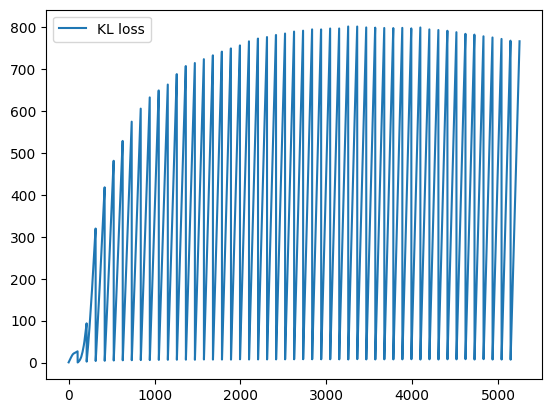

In [ ]:

plt.plot(kl_losses, label='KL loss')
plt.legend()
plt.show()

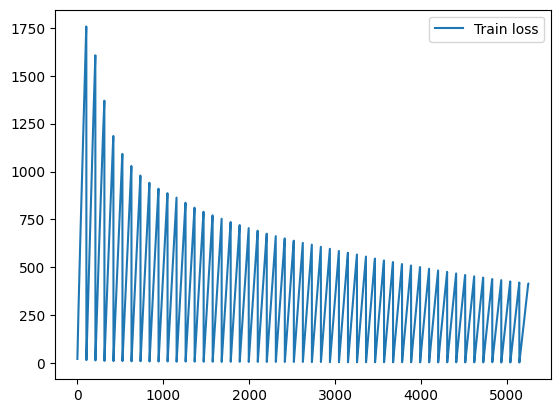

In [ ]:
plt.plot(train_losses, label='Train loss')
plt.legend()
plt.show()

In [ ]:
storn_model.save('storn_model.pt')



Model saved to storn_model.pt


In [ ]:
storn_model = Storn.load('storn_model.pt')

Using device: cpu



RuntimeError: Error(s) in loading state_dict for Storn:
	size mismatch for encoder.inf_mean.weight: copying a param with shape torch.Size([32, 128]) from checkpoint, the shape in current model is torch.Size([16, 128]).
	size mismatch for encoder.inf_mean.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for encoder.inf_logvar.weight: copying a param with shape torch.Size([32, 128]) from checkpoint, the shape in current model is torch.Size([16, 128]).
	size mismatch for encoder.inf_logvar.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([16]).
	size mismatch for decoder.mlp_z_h.linear0.weight: copying a param with shape torch.Size([128, 32]) from checkpoint, the shape in current model is torch.Size([128, 16]).

Test en reconstruction:

Loss de reconstruction: 0.02190830558538437


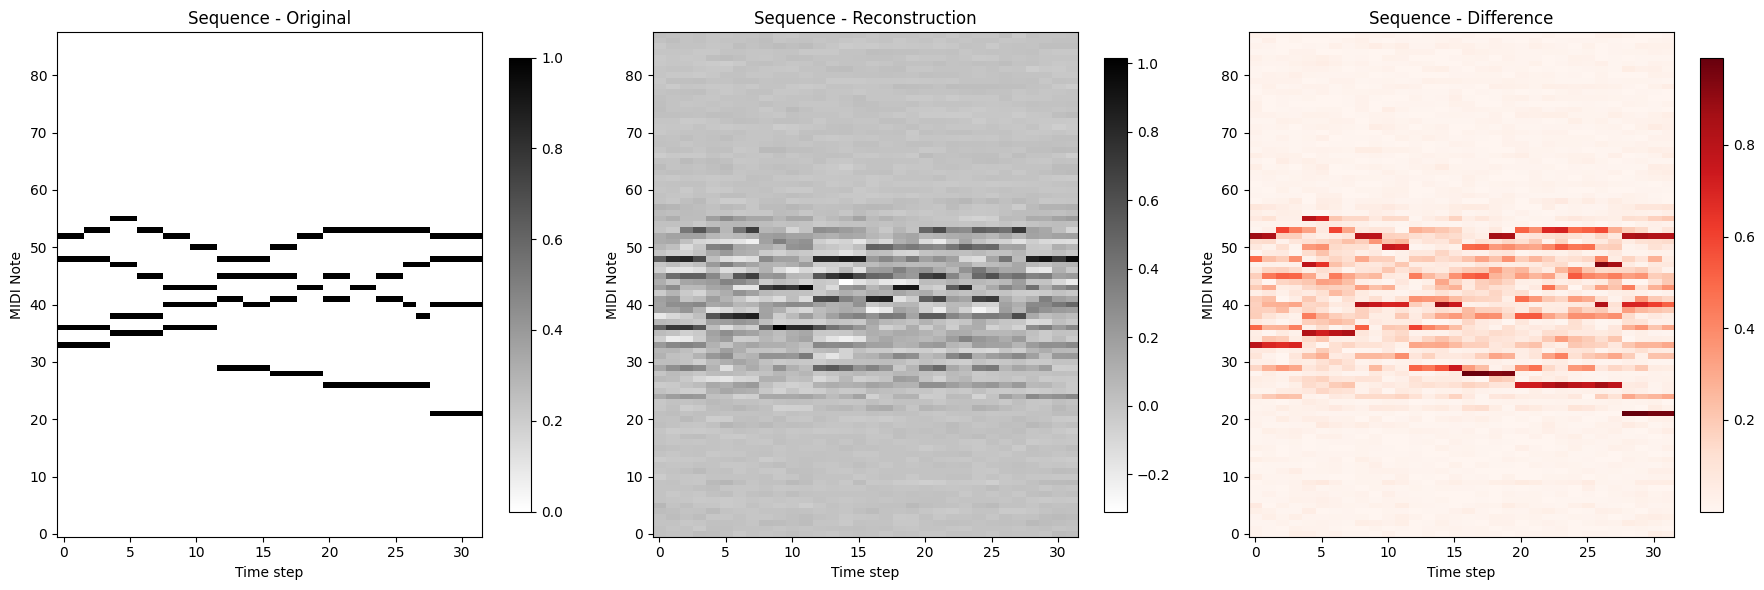

In [ ]:

for batch in test_loader:
    x_test = batch
    break

reconstructed_batch  = storn_model.reconstruct(x_test)

device = storn_model.device
x_test = x_test.to(device)

mse = nn.MSELoss()
loss_reconstruction = mse(reconstructed_batch, x_test)
print("Loss de reconstruction:", loss_reconstruction.item())

plot_piano_roll_comparison(batch, reconstructed_batch, index_sequence=0)




In [ ]:
from IPython.display import display


notes1 = pianoroll_to_midi(x_test[0])
audio1 = play_jsb_sequence(notes1)
display(audio1)

reconstructed_seq = reconstructed_batch[0].detach().cpu().numpy()

print("reconstructed_seq",reconstructed_seq)

reconstructed_seq = (reconstructed_seq > 0.5).astype(np.float32)

print("reconstructed_seq",reconstructed_seq)

midi_reconstruct = pianoroll_to_midi(reconstructed_seq)

audio2  = play_jsb_sequence(midi_reconstruct)

display(audio2)


reconstructed_seq [[ 0.01592092  0.0165953   0.00487668 ... -0.01924681  0.00757761
   0.02630356]
 [ 0.00390504 -0.00405798  0.0070924  ...  0.00848935  0.03296798
   0.01549743]
 [ 0.00422214 -0.00110123 -0.01831541 ... -0.00069155 -0.0027489
   0.00471546]
 ...
 [-0.00585974  0.01244393  0.03568175 ...  0.02747699  0.00227328
  -0.00018135]
 [ 0.04039259 -0.0042652   0.02633806 ...  0.02327301  0.01242492
  -0.00093107]
 [ 0.02887836 -0.0030623   0.01531308 ...  0.02453713  0.01557836
   0.01127175]]
reconstructed_seq [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


Test en génération

In [ ]:
for batch in test_loader:
    x_test = batch
    break


Génération avec une seed

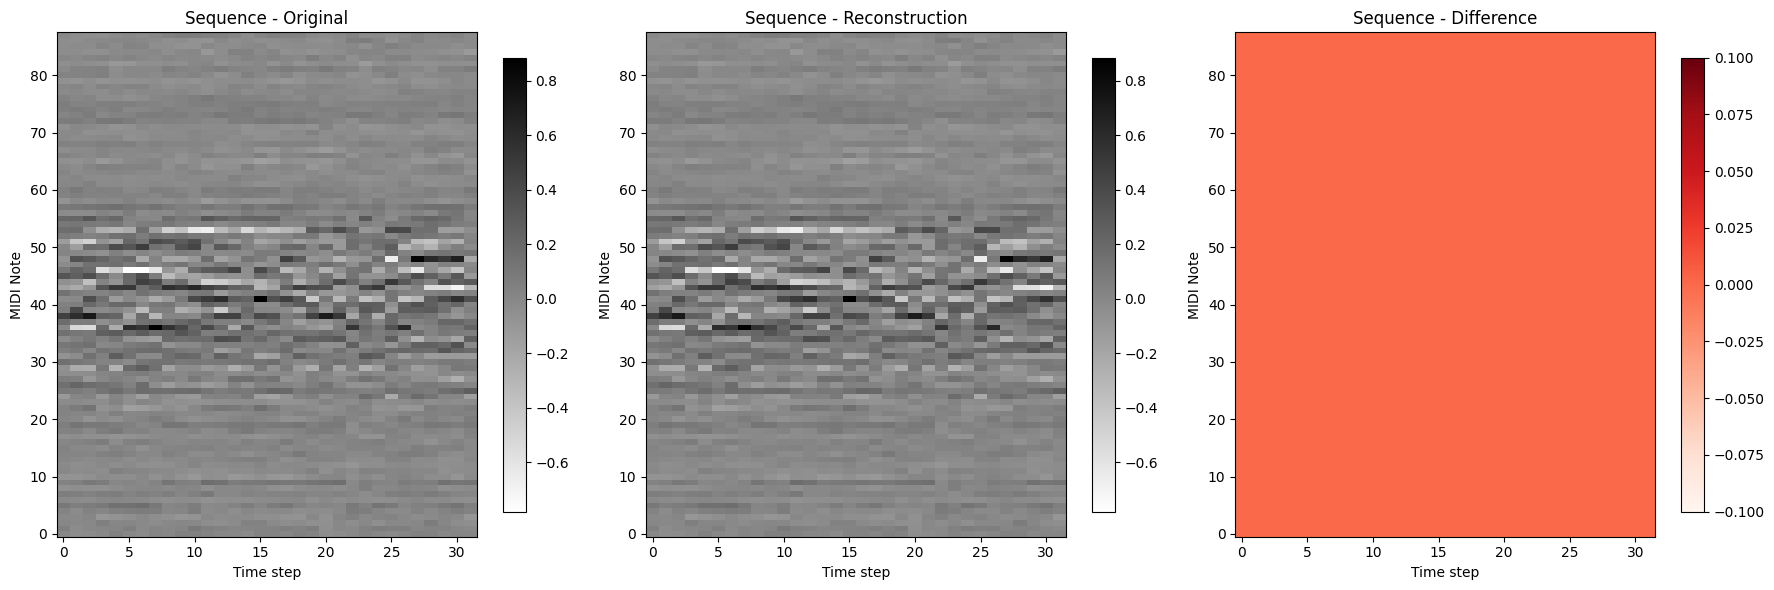

In [ ]:

# Génere un z aléatoire
T = 32
y_generated, z_generated = storn_model.generate(T)

piano_roll_generated = y_generated[0].detach().cpu().numpy()

threshold = 0.5
piano_roll_generated_bin = (piano_roll_generated > threshold).astype(np.int32)

if piano_roll_generated_bin.sum() == 0:
    print("Aucune note activée, essaye un seuil plus bas.")
else:
    midi_generated = pianoroll_to_midi(piano_roll_generated_bin)
    display(play_jsb_sequence(midi_generated))

index_seq = 0
plot_piano_roll_comparison(y_generated, y_generated, index_sequence=index_seq)


In [ ]:
# Dim_b_test = 1

# T_init_batch = torch.randn(Dim_b_test) # [B]
# T_g_batch = torch.randn(Dim_b_test) # [B]
# T_d_batch = torch.randn(Dim_b_test) # [B]

# x1 = resoudre_chaleur_1D(T_initiale=T_init_batch,
#                         T_gauche=T_g_batch,
#                         T_droit=T_d_batch,
#                         dim_x=Dim_x,
#                         dim_t=20*Dim_t)

# T_init_batch = torch.randn(Dim_b_test) # [B]
# T_g_batch = torch.randn(Dim_b_test) # [B]
# T_d_batch = torch.randn(Dim_b_test) # [B]

# x2 = resoudre_chaleur_1D(T_initiale=T_init_batch,
#                         T_gauche=T_g_batch,
#                         T_droit=T_d_batch,
#                         dim_x=Dim_x,
#                         dim_t=20*Dim_t)

In [ ]:
# y_interp = storn_model.interpole(x1, x2, 20)

# animate_tensor_interpolation(y_interp, filename='interpolation.gif')